# Эксперимент №1. Создание модели для разрешения анафоры китайского языка

Используется предобученная модель BERT и датасет WSC Winograd

In [0]:
pip install transformers seqeval

In [0]:
import os
import json
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertConfig
from transformers import BertForTokenClassification, AdamW
from transformers import get_linear_schedule_with_warmup

from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from seqeval.metrics import f1_score, classification_report

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm, trange

import seaborn as sns

from google.colab import drive,files

sns.set(style='darkgrid')
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = torch.device(device)

print(device.type)
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))

cuda
Tesla K80


## Токенизатор

In [0]:
tokenizer = BertTokenizer.from_pretrained('bert-base-chinese')

In [0]:
tokenizer.tokenize("他买了扑热息痛，这种药很有效。") #пример работы токенизатора

['他', '买', '了', '扑', '热', '息', '痛', '，', '这', '种', '药', '很', '有', '效', '。']

## Датасет

Преобразуем WSC Winograd в удобный для работы вид. Используем собственную IO-разметку:

* O - посторонний тег
* S1 - антецедент
* S2 - анафор

In [0]:
def json2io(filename):
    sentences = []
    labels = []
    with open(filename) as f:
        for jline in f:
            data = json.loads(jline)
            if 'label' in data.keys() and data['label'] == 'true':
                span1_tokens = tokenizer.tokenize(data['target']['span1_text'])
                span2_tokens = tokenizer.tokenize(data['target']['span2_text'])
                full_text_tokens = tokenizer.tokenize(data['text'])

                if len(full_text_tokens) != len(data['text']):
                    # print(len(full_text_tokens), len(data['text']))
                    # print(data['text'])
                    # print(full_text_tokens)
                    # print()
                    pass
                else:
                    ft_labels = list('O'*len(full_text_tokens))
                    # S1
                    pos_start = data['target']['span1_index']
                    for i in range(len(span1_tokens)):
                        position = pos_start + i
                        ft_labels[position] = 'S1'
                    
                    # S2
                    pos_start = data['target']['span2_index']
                    for i in range(len(span2_tokens)):
                        position = pos_start + i
                        ft_labels[position] = 'S2'
                    
                    # append data
                    assert len(full_text_tokens) == len(ft_labels)
                    sentences.append(full_text_tokens)
                    labels.append(ft_labels)
            else:
                span1_tokens = tokenizer.tokenize(data['target']['span1_text'])
                span2_tokens = tokenizer.tokenize(data['target']['span2_text'])
                full_text_tokens = tokenizer.tokenize(data['text'])

                if len(full_text_tokens) != len(data['text']):
                    # print(len(full_text_tokens), len(data['text']))
                    # print(data['text'])
                    # print(full_text_tokens)
                    # print()
                    pass
                else:
                    ft_labels = list('O'*len(full_text_tokens))
                    # S1
                    pos_start = data['target']['span1_index']
                    for i in range(len(span1_tokens)):
                        position = pos_start + i
                        ft_labels[position] = 'S1'
                    
                    # S2
                    pos_start = data['target']['span2_index']
                    for i in range(len(span2_tokens)):
                        position = pos_start + i
                        ft_labels[position] = 'S2'
                    
                    # append data
                    assert len(full_text_tokens) == len(ft_labels)
                    sentences.append(full_text_tokens)
                    labels.append(ft_labels)
    return sentences, labels

In [0]:
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
dev = '/content/drive/My Drive/colab_data/Anaphora/dev.json'
test = '/content/drive/My Drive/colab_data/Anaphora/test.json'
train = '/content/drive/My Drive/colab_data/Anaphora/train.json'

In [0]:
sentences_dev, labels_dev = json2io(dev)
sentences_test, labels_test = json2io(test)
sentences_train, labels_train = json2io(train)

assert len(sentences_dev) == len(labels_dev)
assert len(sentences_test) == len(labels_test)
assert len(sentences_train) == len(labels_train)

In [0]:
print(len(labels_train), len(labels_dev), len(labels_test))

1183 304 280


In [0]:
print(sentences_train[0])
print(labels_train[0])

['裂', '开', '的', '伤', '口', '涂', '满', '尘', '土', '，', '里', '面', '有', '碎', '石', '子', '和', '木', '头', '刺', '，', '我', '小', '心', '翼', '翼', '把', '它', '们', '剔', '除', '出', '去', '。']
['O', 'O', 'O', 'S1', 'S1', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'S2', 'S2', 'O', 'O', 'O', 'O', 'O']


In [0]:
tag2idx = {
    'PAD': 0,
    'O': 1,
    'S1': 2,
    'S2': 3
}

In [0]:
tag_values = list(tag2idx.keys())
tag_values

['PAD', 'O', 'S1', 'S2']

Выбираем длину последовательности для подачи на вход нейросети. Длина у всех последовательностей должна быть одинаковой, т.к. они идут в виде тензора. Максимальная длина для Берта - 512, но выбирается другая длина из-за особенностей датасета. Короткие последовательности дополняются нулями.

In [0]:
lenths = [len(sent) for sent in sentences_train]

In [0]:
print('Минимальная длина последовательности:', min(lenths),'\n','Средняя длина последовательности:', round(np.mean(lenths),2),'\n','Максимальная длина последовательности:', max(lenths))

Минимальная длина последовательности: 21 
 Средняя длина последовательности: 62.23 
 Максимальная длина последовательности: 147


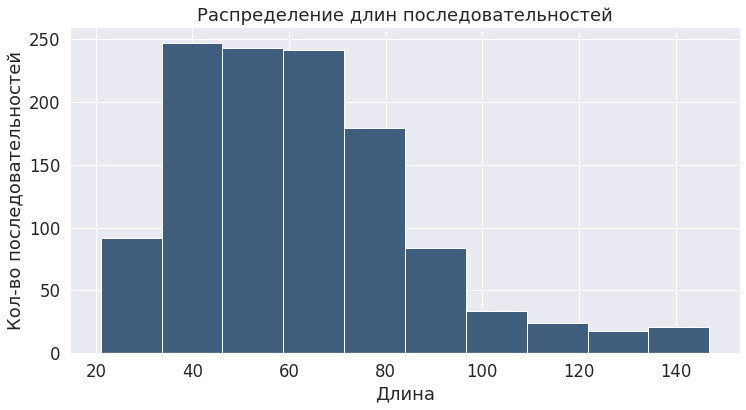

<Figure size 864x648 with 0 Axes>

In [0]:
test = plt.figure()
plt.hist(lenths, color='#3F5D7D')
plt.title('Распределение длин последовательностей')
plt.xlabel('Длина')
plt.ylabel('Кол-во последовательностей')
plt.figure(figsize=(12, 9)) 
test.show()
#test.savefig('distributionlength.png') 
#files.download('distributionlength.png')

In [0]:
# Возьмём максимальную длину входной последовательности
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in sentences_train],
                          maxlen=147,
                          dtype='long',
                          value=0.0,
                          truncating='post',
                          padding='post')
tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in labels_train],
                     maxlen=147,
                     value=tag2idx['PAD'],
                     padding='post',
                     dtype='long',
                     truncating='post')

In [0]:
input_ids[0], tags[0]

(array([6162, 2458, 4638,  839, 1366, 3864, 4007, 2212, 1759, 8024, 7027,
        7481, 3300, 4810, 4767, 2094, 1469, 3312, 1928, 1173, 8024, 2769,
        2207, 2552, 5437, 5437, 2828, 2124,  812, 1188, 7370, 1139, 1343,
         511,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0]),
 arr

In [0]:
# Маска для игнорирования паддингов
attention_masks = [[float(i != 0.0) for i in ii] for ii in input_ids]

In [0]:
# Валидация
input_ids_dev = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in sentences_dev],
                          maxlen=147,
                          dtype='long',
                          value=0.0,
                          truncating='post',
                          padding='post')
tags_dev = pad_sequences([[tag2idx.get(l) for l in lab] for lab in labels_dev],
                     maxlen=147,
                     value=tag2idx['PAD'],
                     padding='post',
                     dtype='long',
                     truncating='post')
attention_masks_dev = [[float(i != 0.0) for i in ii] for ii in input_ids_dev]

In [0]:
# Переводим в тензоры
tr_inputs = torch.tensor(input_ids)
tr_tags = torch.tensor(tags)
tr_masks = torch.tensor(attention_masks)

val_inputs = torch.tensor(input_ids_dev)
val_tags = torch.tensor(tags_dev)
val_masks = torch.tensor(attention_masks_dev)

In [0]:
#Размер батча
BATCH_SIZE = 64
#Загрузчики данных
train_data = TensorDataset(tr_inputs, tr_masks, tr_tags)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=BATCH_SIZE)

valid_data = TensorDataset(val_inputs, val_masks, val_tags)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=BATCH_SIZE)

In [0]:
model = BertForTokenClassification.from_pretrained(
    'bert-base-chinese',
    num_labels=len(tag2idx),
    output_attentions = False,
    output_hidden_states = False
)

In [0]:
FULL_FINETUNING = True
if FULL_FINETUNING:
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]
else:
    param_optimizer = list(model.classifier.named_parameters())
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

optimizer = AdamW(
    optimizer_grouped_parameters,
    lr=3e-5,
    eps=1e-8
)

In [0]:
model.to(device);

In [0]:
epochs = 10
max_grad_norm = 1.0

In [0]:
total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

In [0]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=2).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

# Файн-тюнинг

In [0]:
loss_values, validation_loss_values = [], []

for _ in trange(epochs, desc='Epoch'):
    model.train()
    total_loss = 0

    for step, batch in enumerate(train_dataloader):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        model.zero_grad()

        outputs = model(b_input_ids,
                        token_type_ids=None,
                        attention_mask=b_input_mask,
                        labels=b_labels)

        loss = outputs[0]
        loss.backward()

        total_loss += loss.item()

        # clip_grad_norm_ помогает против взрыва градиентов
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)

        optimizer.step()
        scheduler.step()

    avg_train_loss = total_loss / len(train_dataloader)
    print("Средний лосс обучения: {}".format(avg_train_loss))

    loss_values.append(avg_train_loss)

    # Валидация
    model.eval()
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions , true_labels = [], []

    for batch in valid_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        with torch.no_grad():
            outputs = model(b_input_ids,
                            token_type_ids=None,
                            attention_mask=b_input_mask,
                            labels=b_labels)
            
        logits = outputs[1].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        eval_loss += outputs[0].mean().item()
        eval_accuracy += flat_accuracy(logits, label_ids)
        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        true_labels.extend(label_ids)

        nb_eval_examples += b_input_ids.size(0)
        nb_eval_steps += 1

    eval_loss = eval_loss / nb_eval_steps
    validation_loss_values.append(eval_loss)
    print("Лосс на валидации: {}".format(eval_loss))
    print("Accuracy на валидации: {}".format(eval_accuracy/nb_eval_steps))
    pred_tags = [tag_values[p_i] for p, l in zip(predictions, true_labels)
                                 for p_i, l_i in zip(p, l) if tag_values[l_i] != "PAD"]
    valid_tags = [tag_values[l_i] for l in true_labels
                                  for l_i in l if tag_values[l_i] != "PAD"]
    print("F1 на валидации: {}".format(f1_score(valid_tags, pred_tags)))
    print()

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha)


Средний лосс обучения: 0.331889418394942


Epoch:  10%|█         | 1/10 [00:56<08:32, 56.99s/it]

Лосс на валидации: 0.16362640559673308
Accuracy на валидации: 0.4274659863945578
F1 на валидации: 0.3741701870850936

Средний лосс обучения: 0.15826508716533058


Epoch:  20%|██        | 2/10 [01:54<07:36, 57.07s/it]

Лосс на валидации: 0.1333576485514641
Accuracy на валидации: 0.4296201814058957
F1 на валидации: 0.4437869822485207

Средний лосс обучения: 0.13460036210323634


Epoch:  30%|███       | 3/10 [02:51<06:39, 57.08s/it]

Лосс на валидации: 0.12585018277168275
Accuracy на валидации: 0.42951388888888886
F1 на валидации: 0.40453686200378075

Средний лосс обучения: 0.1279712836993368


Epoch:  40%|████      | 4/10 [03:48<05:42, 57.09s/it]

Лосс на валидации: 0.12282683551311493
Accuracy на валидации: 0.42979024943310656
F1 на валидации: 0.42209807572936064

Средний лосс обучения: 0.11961710570674193


Epoch:  50%|█████     | 5/10 [04:45<04:45, 57.08s/it]

Лосс на валидации: 0.12241620123386383
Accuracy на валидации: 0.4300170068027211
F1 на валидации: 0.412252712188896

Средний лосс обучения: 0.11724703445246346


Epoch:  60%|██████    | 6/10 [05:42<03:48, 57.06s/it]

Лосс на валидации: 0.12076636552810668
Accuracy на валидации: 0.4305555555555555
F1 на валидации: 0.4233483001924311

Средний лосс обучения: 0.11508900476129431


Epoch:  70%|███████   | 7/10 [06:39<02:51, 57.05s/it]

Лосс на валидации: 0.12293767482042313
Accuracy на валидации: 0.4298256802721088
F1 на валидации: 0.4226227470478558

Средний лосс обучения: 0.11191482998822865


Epoch:  80%|████████  | 8/10 [07:36<01:54, 57.05s/it]

Лосс на валидации: 0.12691766619682313
Accuracy на валидации: 0.42970521541950113
F1 на валидации: 0.43708609271523186

Средний лосс обучения: 0.11190701628986158


Epoch:  90%|█████████ | 9/10 [08:33<00:57, 57.03s/it]

Лосс на валидации: 0.12542441487312317
Accuracy на валидации: 0.4300807823129252
F1 на валидации: 0.433066008636644

Средний лосс обучения: 0.10901167282932683


Epoch: 100%|██████████| 10/10 [09:30<00:00, 57.06s/it]

Лосс на валидации: 0.1268450379371643
Accuracy на валидации: 0.4302579365079365
F1 на валидации: 0.4398034398034398



In [0]:
print(classification_report(valid_tags, pred_tags))

           precision    recall  f1-score   support

       S1       0.42      0.03      0.06       756
       S2       0.78      0.87      0.82       387

micro avg       0.74      0.31      0.44      1143
macro avg       0.54      0.31      0.32      1143



Модель очень хорошо научилась определять местоимение, но практически никогда не угадывает антецедент. Видимо, это связано с тем, что местоимения часто повторяются, а в качестве антецедента используются различные слова. Улучшить это можно только увеличением датасета.

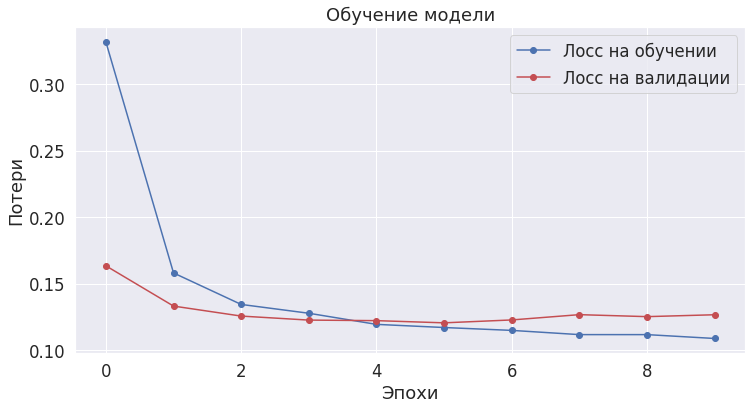

In [0]:
modelloss = plt.figure()
plt.plot(loss_values, 'b-o', label='Лосс на обучении')
plt.plot(validation_loss_values, 'r-o', label='Лосс на валидации')

plt.title('Обучение модели')
plt.xlabel('Эпохи')
plt.ylabel('Потери')
plt.legend()
modelloss.show()
#modelloss.savefig('modelloss.png') 
#files.download('modelloss.png')

видно, что при данных параметрах уже после 2 эпохи пошло переобучение.

In [0]:
!mkdir '/content/drive/My Drive/colab_data/Anaphora/BERT_BASELINE/'
model.save_pretrained('/content/drive/My Drive/colab_data/Anaphora/BERT_BASELINE/')
tokenizer.save_pretrained('/content/drive/My Drive/colab_data/Anaphora/BERT_BASELINE/')

mkdir: cannot create directory ‘/content/drive/My Drive/colab_data/Anaphora/BERT_BASELINE/’: File exists


('/content/drive/My Drive/colab_data/Anaphora/BERT_BASELINE/vocab.txt',
 '/content/drive/My Drive/colab_data/Anaphora/BERT_BASELINE/special_tokens_map.json',
 '/content/drive/My Drive/colab_data/Anaphora/BERT_BASELINE/added_tokens.json')

# Наиболее частые анафоры

In [0]:
dev = '/content/drive/My Drive/colab_data/Anaphora/dev.json'
test = '/content/drive/My Drive/colab_data/Anaphora/test.json'
train = '/content/drive/My Drive/colab_data/Anaphora/train.json'

In [0]:
import collections
import pandas as pd

In [0]:
with open(train) as f:
    wordcount = {}
    for jline in f:
        data = json.loads(jline)
        span2_text = data['target']['span2_text']
        if span2_text not in wordcount:
            wordcount[span2_text] = 1
        else:
            wordcount[span2_text] += 1

word_counter = collections.Counter(wordcount)

In [0]:
word_counter.most_common()

[('他', 521),
 ('她', 248),
 ('它', 232),
 ('他们', 136),
 ('它们', 76),
 ('她们', 25),
 ('其', 4),
 ('她俩', 2)]

In [0]:
#df = pd.DataFrame(word_counter.most_common(), columns = ['Word', 'Count'],fontproperties=fontprop)
#ax = df.plot.bar(x='Word',y='Count')